In [1]:
import sys # for automation and parallelization: set manual to false when run by a launcher
manual, scenario = (True, 'base') if 'ipykernel' in sys.argv[0] else (False, sys.argv[1])

# START

In [2]:
import sys
sys.path.insert(0, r'../../../quetzal')

from quetzal.io.gtfs_reader import importer
import geopandas as gpd
from shapely import geometry
from quetzal.model import stepmodel

if manual:
    %matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 9]

PyTables is not installed. No support for HDF output.


In [3]:
training_folder = '../../'
input_folder = training_folder + r'inputs/'

In [4]:
zones = gpd.read_file(r'../../inputs/zones/zones.geojson')
hull = geometry.MultiPolygon(zones['geometry'].values).buffer(1e-3)

In [5]:
full_feed = importer.GtfsImporter(path=input_folder + r'/IDFM_gtfs.zip', dist_units='m') 
# downloaded from https://data.iledefrance-mobilites.fr/explore/dataset/offre-horaires-tc-gtfs-idf/table/

In [6]:
feed_r = full_feed.restrict(
    dates=['20200204'] # the dates must be within the feed start and end dates
)

In [7]:
# temporal restriction
time_range = ['08:00:00', '09:00:00'] 
feed_t = feed_r.restrict(time_range=time_range)

In [8]:
# def spatial_restrict(feed, polygon, how='inner'):
#     f = feed.copy()
#     stops = f.stops.copy()
#     stops['geometry'] = stops.apply(
#         lambda r: geometry.Point([r['stop_lon'], r['stop_lat']]),
#         axis=1
#     )
#     stops['included'] = stops['geometry'].apply(lambda g: polygon.contains(g))
#     f.stops = f.stops.loc[stops['included'] == True]

#     # relations
#     f.stop_times = f.stop_times.loc[f.stop_times['stop_id'].isin(f.stops['stop_id'])]
#     f.transfers = f.transfers.loc[f.transfers['from_stop_id'].isin(f.stops['stop_id'])]
#     f.transfers = f.transfers.loc[f.transfers['to_stop_id'].isin(f.stops['stop_id'])]
#     relevant_trips = (f.stop_times['trip_id'])
#     f = f.restrict(trip_ids=relevant_trips)
#     if how == 'inner':
#         return f
#     else:
#         return feed.restrict(trip_ids=relevant_trips)

# feed_s = spatial_restrict(feed_t, polygon=hull, how='inner')

In [9]:
# spatial restriction
feed_s = feed_t.restrict(polygon_4326=hull)

In [10]:
# simplification
feed = feed_s.copy()
feed.group_services()
feed.build_stop_clusters(distance_threshold=300)
feed.build_patterns(on='cluster_id')

In [11]:
# frequency conversion
feed_frequencies = feed.convert_to_frequencies(time_range=time_range)

In [12]:
# to quetzal links and nodes
feed_frequencies.build_links_and_nodes()
feed_frequencies.build_geometries(use_utm=False)

export geometries in epsg: 32631


# rename route types

In [13]:
mapping = {0:'tram', 1:'subway', 2:'rail', 3:'bus',
    4:'ferry', 5:'cable_car', 6:'gondola', 7:'funicular'}

feed_frequencies.links['route_type'] = feed_frequencies.links['route_type'].apply(
    lambda t: mapping.get(t, t)
)

In [14]:
feed_frequencies.nodes.head(1)

,stop_id,stop_name,stop_desc,zone_id,stop_url,location_type,parent_station,wheelchair_boarding,cluster_id,geometry
315,StopArea:8738102,PORTE MAILLOT,NaN,NaN,NaN,1,NaN,NaN,187,POINT (2.28258 48.87812)


# export 

In [15]:
sm = stepmodel.StepModel(epsg=4326, coordinates_unit='degree')
sm.links = feed_frequencies.links
sm.nodes = feed_frequencies.nodes#[['geometry', 'stop_id', 'stop_name', 'location_type']]
sm.zones = zones

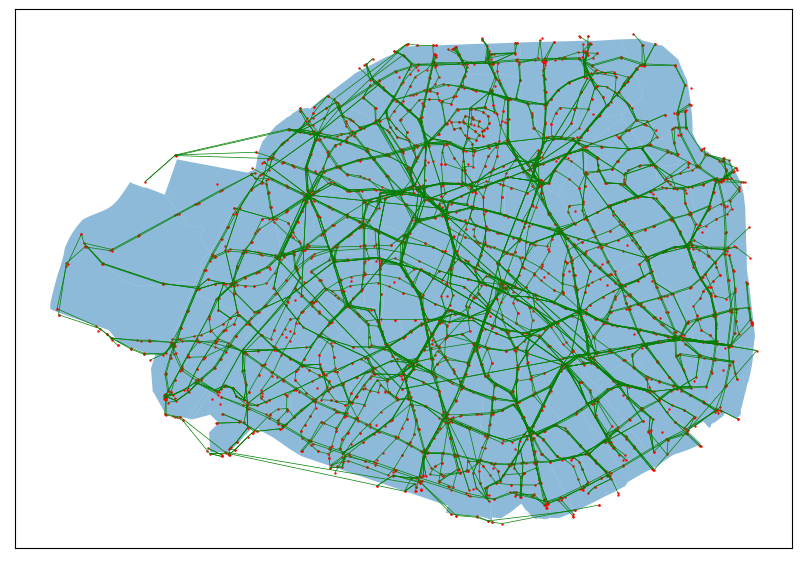

In [16]:
ax = sm.plot('zones', alpha=0.5, figsize=[17, 7])
ax = sm.plot('links', linewidth=0.5, color='green', ax=ax)
plot= sm.plot('nodes', markersize=0.5, color='red', ax=ax)

In [17]:
sm.to_json(input_folder + 'gtfs', only_attributes=['links', 'nodes'])

to_hdf(overwriting): 100%|██████████| 9/9 [00:02<00:00,  3.11it/s]


In [18]:
sm.to_zippedpickles(training_folder + r'models/base/base')

zones: 100%|██████████| 9/9 [00:00<00:00, 37.18it/s]


# END